## Section 1: Environment Setup and Basic Board Implementation

In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import random
from collections import deque

In [73]:
@dataclass
class Move:
    start_pos: Tuple[int, int]
    end_pos: Tuple[int, int]
    captures: List[Tuple[int, int]]  # positions of captured places

In [74]:
class CheckersBoard:
    def __init__(self):
        self.BOARD_SIZE = 8
        self.reset()
    
    def reset(self):
        self.board = np.zeros((self.BOARD_SIZE, self.BOARD_SIZE))
        # Initialize pieces: 1 for red (player 1), -1 for black (player 2)
        # Set up the initial board position
        for row in range(3):  # Red pieces (top)
            for col in range(self.BOARD_SIZE):
                if (row + col) % 2 == 1:
                    self.board[row][col] = 1
        for row in range(5, self.BOARD_SIZE):  # Black pieces (bottom)
            for col in range(self.BOARD_SIZE):
                if (row + col) % 2 == 1:
                    self.board[row][col] = -1
        self.current_player = 1  # Red always starts
        return self.get_state()

    def get_state(self):
        state = np.zeros((4, self.BOARD_SIZE, self.BOARD_SIZE))
        state[0] = (self.board == 1).astype(float)
        state[1] = (self.board == -1).astype(float)
        state[2] = (self.board == 2).astype(float)
        state[3] = (self.board == -2).astype(float)
        return state
    
    def get_legal_moves(self) -> List[Move]:
        """Get all legal moves for the current player."""
        moves = []
        # First check for any capture moves (these are mandatory in checkers)
        for row in range(self.BOARD_SIZE):
            for col in range(self.BOARD_SIZE):
                if self.board[row][col] * self.current_player > 0:  # If piece belongs to current player
                    piece_captures = self._get_capture_moves(row, col)
                    moves.extend(piece_captures)

        # If no captures are available, get regular moves
        if not moves:
            for row in range(self.BOARD_SIZE):
                for col in range(self.BOARD_SIZE):
                    if self.board[row][col] * self.current_player > 0:
                        piece_moves = self._get_regular_moves(row, col)
                        moves.extend(piece_moves)
        return moves

    def _get_piece_moves(self, row: int, col: int) -> List[Move]:
        """Get all possible moves for a specific piece."""
        # Check for captures first (mandatory)
        captures = self._get_capture_moves(row, col)
        if captures:
            return captures

        # If no captures, return regular moves
        return self._get_regular_moves(row, col)

    def _get_regular_moves(self, row: int, col: int) -> List[Move]:
        """Get non-capturing moves for a piece."""
        moves = []
        piece = self.board[row][col]

        # Define move directions
        if piece == 1:  # Red pieces move down
            directions = [(1, -1), (1, 1)]
        elif piece == -1:  # Black pieces move up
            directions = [(-1, -1), (-1, 1)]
        elif abs(piece) == 2:  # Kings can move in all directions
            directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
        else:
            return moves

        # Check each direction
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if (0 <= new_row < self.BOARD_SIZE and
                0 <= new_col < self.BOARD_SIZE and
                self.board[new_row][new_col] == 0):  # Empty square
                moves.append(Move(
                    start_pos=(row, col),
                    end_pos=(new_row, new_col),
                    captures=[]
                ))

        return moves

    def _get_capture_moves(self, row: int, col: int) -> List[Move]:
        """Get capturing moves for a piece."""
        moves = []
        piece = self.board[row][col]

        # Define capture directions based on piece type
        directions = []
        if piece == 1 or piece == 2:  # Player 1 pieces or kings capture up
            directions.extend([(-1, -1), (-1, 1)])
        if piece == -1 or piece == -2:  # Player 2 pieces or kings capture down
            directions.extend([(1, -1), (1, 1)])
        if abs(piece) == 2:  # Kings can capture in all directions
            directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]

        # Check each direction for captures
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            jump_row, jump_col = row + 2*dr, col + 2*dc

            if (0 <= jump_row < self.BOARD_SIZE and
                0 <= jump_col < self.BOARD_SIZE and
                self.board[new_row][new_col] * self.current_player < 0 and  # Enemy piece
                self.board[jump_row][jump_col] == 0):  # Empty landing square

                moves.append(Move(
                    start_pos=(row, col),
                    end_pos=(jump_row, jump_col),
                    captures=[(new_row, new_col)]
                ))

                # Check for multiple captures
                # Temporarily make the capture move and look for more captures
                temp_board = self.board.copy()
                temp_board[jump_row][jump_col] = temp_board[row][col]
                temp_board[row][col] = 0
                temp_board[new_row][new_col] = 0

                # Recursively find additional captures
                additional_captures = self._get_additional_captures(
                    jump_row, jump_col, temp_board, [(new_row, new_col)])
                moves.extend(additional_captures)

        return moves

    def _get_additional_captures(self, row: int, col: int,
                            temp_board: np.ndarray,
                            captured_pieces: List[Tuple[int, int]]) -> List[Move]:
        """Recursively find additional captures after initial capture."""
        moves = []
        piece = temp_board[row][col]

        # Define capture directions (same logic as _get_capture_moves)
        directions = []
        if piece == 1 or piece == 2:
            directions.extend([(-1, -1), (-1, 1)])
        if piece == -1 or piece == -2:
            directions.extend([(1, -1), (1, 1)])
        if abs(piece) == 2:
            directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]

        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            jump_row, jump_col = row + 2*dr, col + 2*dc

            if (0 <= jump_row < self.BOARD_SIZE and
                0 <= jump_col < self.BOARD_SIZE and
                temp_board[new_row][new_col] * self.current_player < 0 and
                temp_board[jump_row][jump_col] == 0 and
                (new_row, new_col) not in captured_pieces):

                new_captures = captured_pieces + [(new_row, new_col)]
                moves.append(Move(
                    start_pos=(row, col),
                    end_pos=(jump_row, jump_col),
                    captures=new_captures
                ))

                # Continue looking for more captures
                next_temp_board = temp_board.copy()
                next_temp_board[jump_row][jump_col] = next_temp_board[row][col]
                next_temp_board[row][col] = 0
                next_temp_board[new_row][new_col] = 0

                additional_moves = self._get_additional_captures(
                    jump_row, jump_col, next_temp_board, new_captures)
                moves.extend(additional_moves)

        return moves

    def make_move(self, move: Move) -> bool:
        """Execute a move on the board."""
        start_row, start_col = move.start_pos
        end_row, end_col = move.end_pos

        # Validate move
        if not (0 <= start_row < self.BOARD_SIZE and
                0 <= start_col < self.BOARD_SIZE and
                0 <= end_row < self.BOARD_SIZE and
                0 <= end_col < self.BOARD_SIZE):
            return False

        # Verify piece belongs to current player
        if self.board[start_row][start_col] * self.current_player <= 0:
            return False

        # Execute move
        piece = self.board[start_row][start_col]
        self.board[end_row][end_col] = piece
        self.board[start_row][start_col] = 0

        # Remove captured pieces
        for capture_row, capture_col in move.captures:
            self.board[capture_row][capture_col] = 0

        # King promotion
        if (piece == 1 and end_row == 0) or (piece == -1 and end_row == self.BOARD_SIZE - 1):
            self.board[end_row][end_col] = piece * 2  # Convert to king

        # Switch players
        self.current_player *= -1

        return True

1. **Mandatory captures**: The code first checks for any capturing moves, which are mandatory in (English) draughts. Only if no captures are available will regular moves be considered.
2. **Kings**: The code handles both regular pieces and kings (represented by 2 and -2).
3. **Multiple Captures**: The code supports multiple captures in a single turn through recursive checking of additional captures after the initial capture.
4. **King Promotion**: Pieces are automatically prompted to kings when they reach the opposite end of the board.
5. **Move Validation**: The code includes basic validation of moves, including checking board boundaries and piece ownership.

Initial board state:


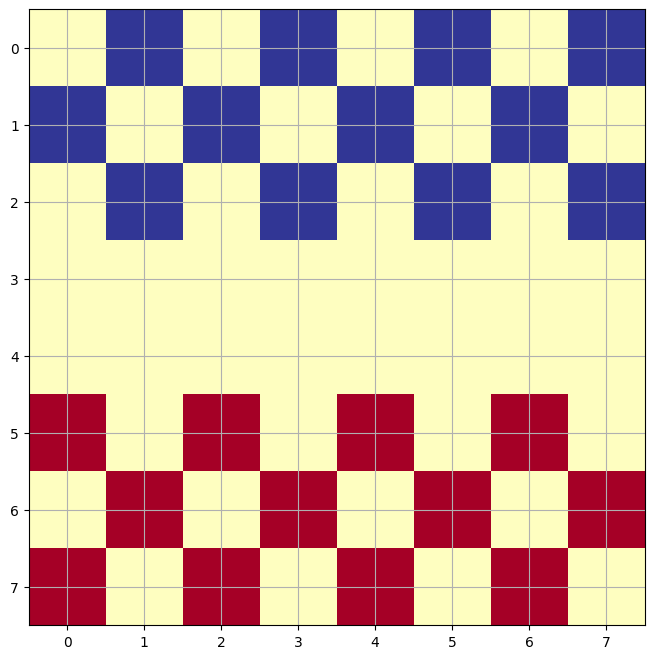

Number of legal moves: 7
Selected move:
From: (2, 1)
To: (3, 0)
Captures: []
Move successful: True

Board after move:


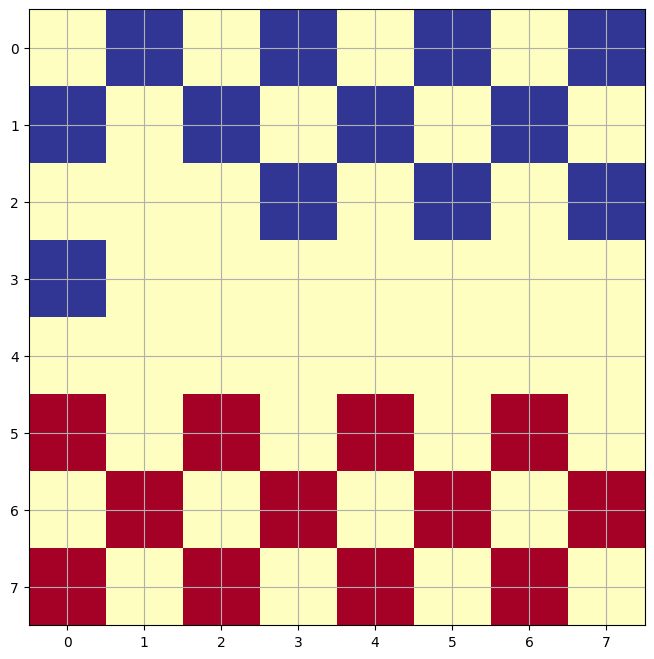

In [75]:
def visualize_board(board: CheckersBoard):
    plt.figure(figsize=(8, 8))
    plt.imshow(board.board, cmap='RdYlBu')
    plt.grid(True)
    plt.show()

# Test the board and moves
board = CheckersBoard()
print("Initial board state:")
visualize_board(board)

legal_moves = board.get_legal_moves()
print(f"Number of legal moves: {len(legal_moves)}")

if legal_moves:
    move = legal_moves[0]
    print(f"Selected move:")
    print(f"From: {move.start_pos}")
    print(f"To: {move.end_pos}")
    print(f"Captures: {move.captures}")

    # Make the move
    success = board.make_move(move)
    print(f"Move successful: {success}")

    print("\nBoard after move:")
    visualize_board(board)
else:
    print("No legal moves found!")

## Section 2: Neural Network Architecture

In [76]:
class CheckersNet(nn.Module):
    def __init__(self):
        super(CheckersNet, self).__init__()

        # Shared layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Policy head (64 outputs for all possible destination squares)
        self.policy_head = nn.Sequential(
            nn.Conv2d(256, 128, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 64),  # 8*8 possible positions
            nn.LogSoftmax(dim=1)
        )

        # Value head
        self.value_head = nn.Sequential(
            nn.Conv2d(256, 32, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value

In [77]:
def test_model():
    model = CheckersNet()
    sample_input = torch.randn(1, 4, 8, 8)
    policy, value = model(sample_input)
    print(f"Policy output shape: {policy.shape}")
    print(f"Value output shape: {value.shape}")
    return model

## Section 3: Training Infrastructure

In [78]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, policy, value, reward):
        self.buffer.append((state, policy, value, reward))

    def sample(self, batch_size: int):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        batch = random.sample(self.buffer, batch_size)
        states, policies, values, rewards = zip(*batch)
        return (torch.stack(states),
                torch.stack(policies),
                torch.stack(values),
                torch.tensor(rewards))

    def __len__(self):
        return len(self.buffer)

In [79]:
class CheckersTrainer:
    def __init__(self, model: CheckersNet, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        self.replay_buffer = ReplayBuffer(10000)
        self.batch_size = 32

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return None

        states, policies, values, rewards = self.replay_buffer.sample(self.batch_size)
        states = states.to(self.device)
        policies = policies.to(self.device)
        values = values.to(self.device)
        rewards = rewards.to(self.device)

        self.optimizer.zero_grad()
        pred_policies, pred_values = self.model(states)

        policy_loss = F.cross_entropy(pred_policies, policies)
        value_loss = F.mse_loss(pred_values.squeeze(), values)
        total_loss = policy_loss + value_loss

        total_loss.backward()
        self.optimizer.step()

        return total_loss.item()

In [80]:
class SelfPlay:
    def __init__(self, model: CheckersNet, device: str):
        self.model = model
        self.device = device
        self.board = CheckersBoard()
        self.temperature = 1.0  # Temperature parameter for exploration
        self.board_size = 8
        self.num_actions = self.board_size * self.board_size  # total possible positions

    def _encode_move(self, move: Move) -> torch.Tensor:
        """
        Encode a move into a one-hot vector.
        For an 8x8 board, we encode moves as indices in a 64-element vector
        where the index represents the destination square.
        """
        encoding = torch.zeros(self.num_actions)  # 64 possible positions
        start_row, start_col = move.start_pos
        end_row, end_col = move.end_pos

        # Convert end position to single index (0-63)
        move_idx = end_row * self.board_size + end_col
        encoding[move_idx] = 1
        return encoding

    def _decode_policy(self, policy: torch.Tensor, legal_moves: List[Move]) -> List[float]:
        """Convert policy output to move probabilities for legal moves."""
        move_probs = []

        for move in legal_moves:
            # Get the probability for the destination square
            end_row, end_col = move.end_pos
            move_idx = end_row * self.board_size + end_col
            prob = policy[move_idx].item()
            move_probs.append(prob)

        # Apply temperature and normalize
        move_probs = np.array(move_probs)
        move_probs = np.exp(move_probs / self.temperature)
        # Add small constant to prevent division by zero
        move_probs = move_probs + 1e-8
        move_probs = move_probs / np.sum(move_probs)

        return move_probs

    def _select_move(self, policy: torch.Tensor, legal_moves: List[Move]) -> Move:
        """Select a move based on the policy network output."""
        if not legal_moves:
            return None

        # Convert policy output to move probabilities
        move_probs = self._decode_policy(policy, legal_moves)

        # During training, sample moves according to their probabilities
        try:
            move_idx = np.random.choice(len(legal_moves), p=move_probs)
            return legal_moves[move_idx]
        except ValueError as e:
            print(f"Error in move selection: {e}")
            print(f"Move probabilities: {move_probs}")
            print(f"Sum of probabilities: {np.sum(move_probs)}")
            # Fall back to random selection if there's an issue
            return random.choice(legal_moves)

    def play_game(self) -> List[Tuple]:
        game_memory = []
        state = self.board.reset()
        max_moves = 200  # Prevent infinite games
        move_count = 0

        while move_count < max_moves:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                policy, value = self.model(state_tensor)

            legal_moves = self.board.get_legal_moves()
            if not legal_moves:
                break

            # Select move using the policy network
            selected_move = self._select_move(policy.squeeze(), legal_moves)
            if selected_move is None:
                break

            # Store the current state and action
            move_encoding = self._encode_move(selected_move)
            game_memory.append((
                state_tensor.squeeze(),
                move_encoding,
                value.squeeze()
            ))

            # Make the move
            self.board.make_move(selected_move)
            move_count += 1

        return game_memory

## Section 4: Training Loop and Evaluation

In [85]:
def train(num_episodes: int = 300):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CheckersNet().to(device)
    trainer = CheckersTrainer(model, device)
    self_play = SelfPlay(model, device)

    losses = []
    for episode in range(num_episodes):
        # Self-play phase
        game_memory = self_play.play_game()

        if game_memory:  # Only process if game generated moves
            # Process game result and add to replay buffer
            for state, move_encoding, value in game_memory:
                trainer.replay_buffer.push(
                    state,
                    move_encoding,
                    value,
                    0  # Reward will be updated later
                )

            # Training phase
            loss = trainer.train_step()
            if loss is not None:
                losses.append(loss)

            # Logging and visualization
            if episode % 10 == 0:
                clear_output(wait=True)
                plt.plot(losses)
                plt.title('Training Loss')
                plt.show()
                print(f"Episode {episode}, Loss: {loss if loss else 'N/A'}")

        if episode % 100 == 0:
            print(f"Completed episode {episode}")

In [89]:
def evaluate_model(model: CheckersNet, num_games: int = 100):
    """
    Evaluate model performance by playing against a random-move baseline.
    Returns win rate against the baseline.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set model to evaluation mode
    wins = 0
    draws = 0
    losses = 0

    for game in range(num_games):
        board = CheckersBoard()
        move_count = 0
        max_moves = 200  # Prevent infinite games

        while move_count < max_moves:
            legal_moves = board.get_legal_moves()
            if not legal_moves:
                # Current player has no moves - they lose
                if board.current_player == 1:  # Model (playing as red) loses
                    losses += 1
                else:  # Model wins
                    wins += 1
                break

            if board.current_player == 1:  # Model's turn (red)
                # Get model's move
                state = board.get_state()
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    policy, _ = model(state_tensor)

                # Convert policy to probabilities and select best legal move
                policy = policy.squeeze()
                move_probs = []
                for move in legal_moves:
                    end_row, end_col = move.end_pos
                    move_idx = end_row * 8 + end_col
                    move_probs.append(policy[move_idx].item())

                best_move_idx = np.argmax(move_probs)
                selected_move = legal_moves[best_move_idx]

            else:  # Random opponent's turn (black)
                selected_move = random.choice(legal_moves)

            board.make_move(selected_move)
            move_count += 1

            # Check for draw (too many moves)
            if move_count >= max_moves:
                draws += 1
                break

        # Progress update
        if (game + 1) % 10 == 0:
            print(f"Completed {game + 1} games. Current stats:")
            print(f"Wins: {wins}, Losses: {losses}, Draws: {draws}")

    win_rate = wins / num_games
    draw_rate = draws / num_games
    loss_rate = losses / num_games

    print("\nEvaluation Results:")
    print(f"Games played: {num_games}")
    print(f"Win rate: {win_rate:.2%}")
    print(f"Draw rate: {draw_rate:.2%}")
    print(f"Loss rate: {loss_rate:.2%}")

    return win_rate, draw_rate, loss_rate

In [90]:
def visualize_game(model: CheckersNet):
    """
    Play and visualize a complete game using the trained model against a random opponent.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    board = CheckersBoard()
    move_count = 0
    max_moves = 200

    def display_board_state(board, move=None):
        plt.figure(figsize=(8, 8))

        # Create a more detailed visualization
        plt.imshow(board.board, cmap='RdYlBu', vmin=-2, vmax=2)

        # Add grid
        plt.grid(True)

        # Add piece annotations
        for i in range(8):
            for j in range(8):
                val = board.board[i][j]
                if val != 0:
                    color = 'white' if val > 0 else 'black'
                    plt.text(j, i, 'K' if abs(val) == 2 else 'P',
                            ha='center', va='center', color=color)

        # If a move was made, highlight it
        if move:
            start_y, start_x = move.start_pos
            end_y, end_x = move.end_pos
            plt.plot(start_x, start_y, 'go', markersize=15, alpha=0.5)  # Green circle for start
            plt.plot(end_x, end_y, 'ro', markersize=15, alpha=0.5)      # Red circle for end

            # Highlight captures
            for capture_y, capture_x in move.captures:
                plt.plot(capture_x, capture_y, 'rx', markersize=15)      # Red X for captures

        plt.title(f"Move {move_count}: {'Red (Model)' if board.current_player == 1 else 'Blue (Random)'} to play")
        plt.show()
        plt.close()

        # Add a small delay to make the visualization easier to follow
        time.sleep(1)

    # Play the game
    print("Starting game visualization...")
    display_board_state(board)

    while move_count < max_moves:
        legal_moves = board.get_legal_moves()
        if not legal_moves:
            print(f"Game Over! {'Blue (Random)' if board.current_player == 1 else 'Red (Model)'} wins!")
            break

        if board.current_player == 1:  # Model's turn (red)
            # Get model's move
            state = board.get_state()
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                policy, value = model(state_tensor)

            # Convert policy to probabilities and select best legal move
            policy = policy.squeeze()
            move_probs = []
            for move in legal_moves:
                end_row, end_col = move.end_pos
                move_idx = end_row * 8 + end_col
                move_probs.append(policy[move_idx].item())

            best_move_idx = np.argmax(move_probs)
            selected_move = legal_moves[best_move_idx]
            print(f"Model's confidence: {torch.sigmoid(value).item():.2f}")

        else:  # Random opponent's turn (black)
            selected_move = random.choice(legal_moves)

        # Make the move and display the new state
        board.make_move(selected_move)
        move_count += 1
        display_board_state(board, selected_move)

        if move_count >= max_moves:
            print("Game drawn due to move limit!")
            break

    print(f"Game completed in {move_count} moves.")

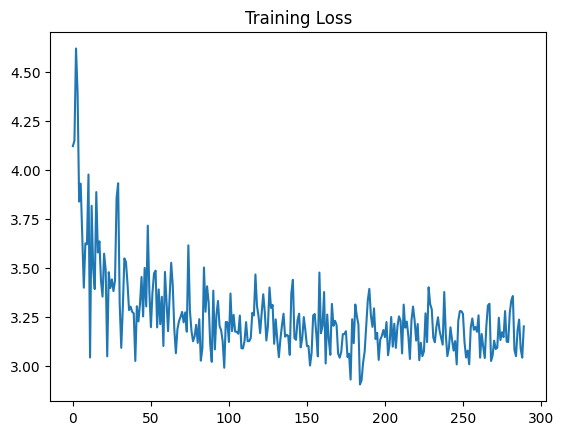

Episode 290, Loss: 3.1999263763427734


In [88]:
train()

In [91]:
win_rate, draw_rate, loss_rate = evaluate_model(model)

Completed 10 games. Current stats:
Wins: 4, Losses: 6, Draws: 0
Completed 20 games. Current stats:
Wins: 7, Losses: 13, Draws: 0
Completed 30 games. Current stats:
Wins: 9, Losses: 20, Draws: 1
Completed 40 games. Current stats:
Wins: 10, Losses: 29, Draws: 1
Completed 50 games. Current stats:
Wins: 18, Losses: 31, Draws: 1
Completed 60 games. Current stats:
Wins: 21, Losses: 38, Draws: 1
Completed 70 games. Current stats:
Wins: 24, Losses: 45, Draws: 1
Completed 80 games. Current stats:
Wins: 29, Losses: 50, Draws: 1
Completed 90 games. Current stats:
Wins: 34, Losses: 55, Draws: 1
Completed 100 games. Current stats:
Wins: 39, Losses: 60, Draws: 1

Evaluation Results:
Games played: 100
Win rate: 39.00%
Draw rate: 1.00%
Loss rate: 60.00%


Starting game visualization...


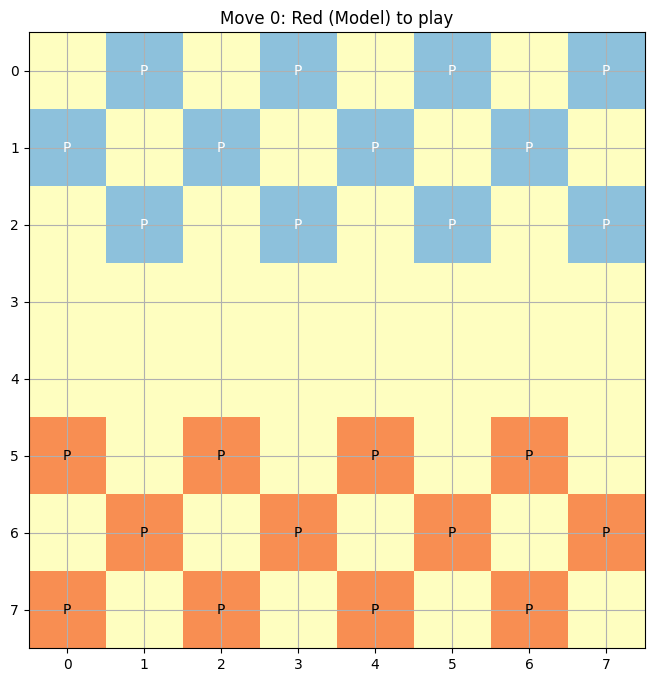

Model's confidence: 0.50


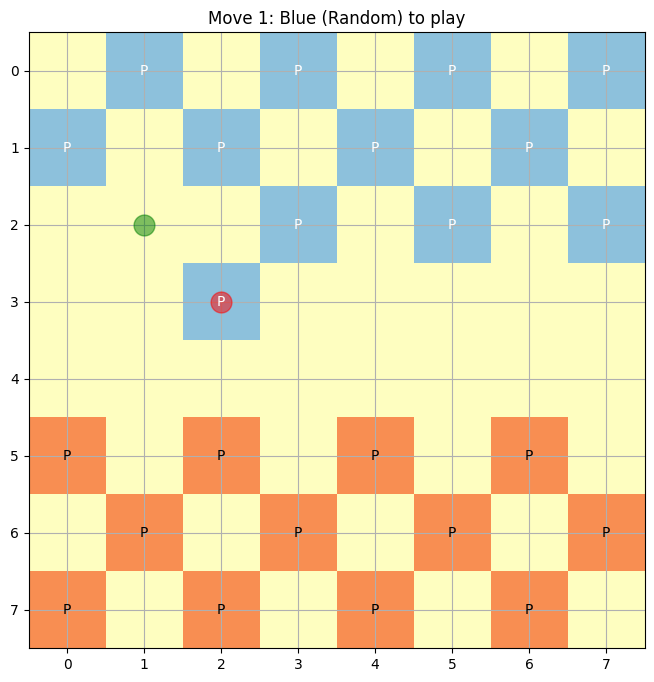

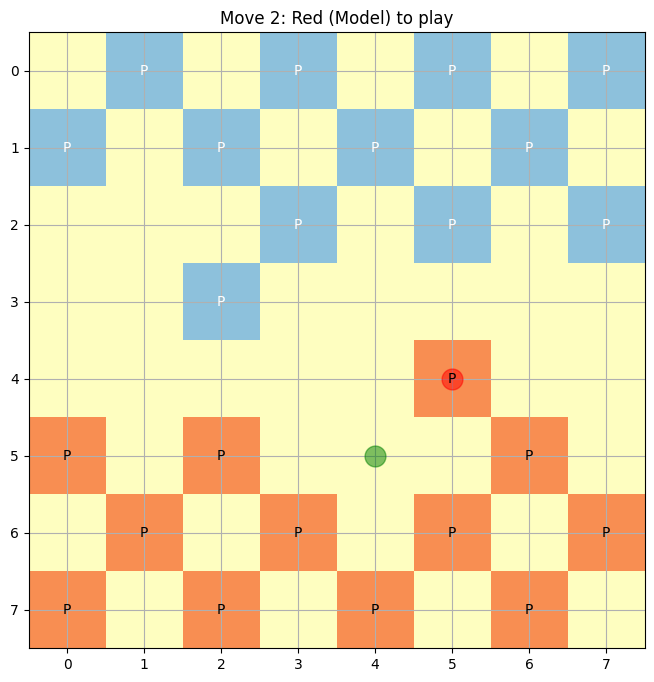

Model's confidence: 0.50


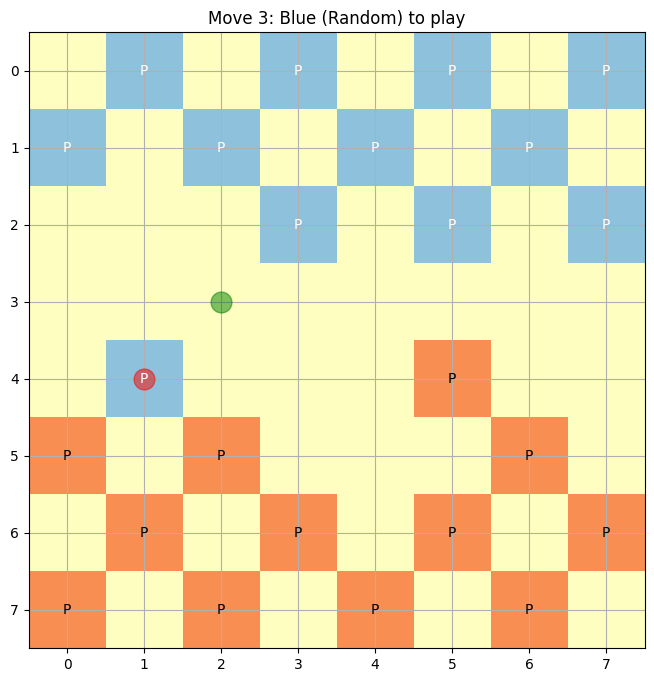

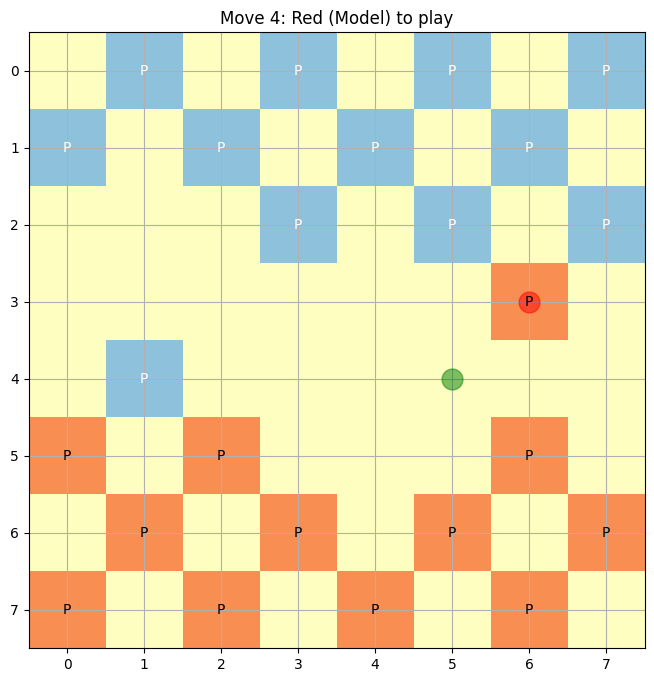

Model's confidence: 0.50


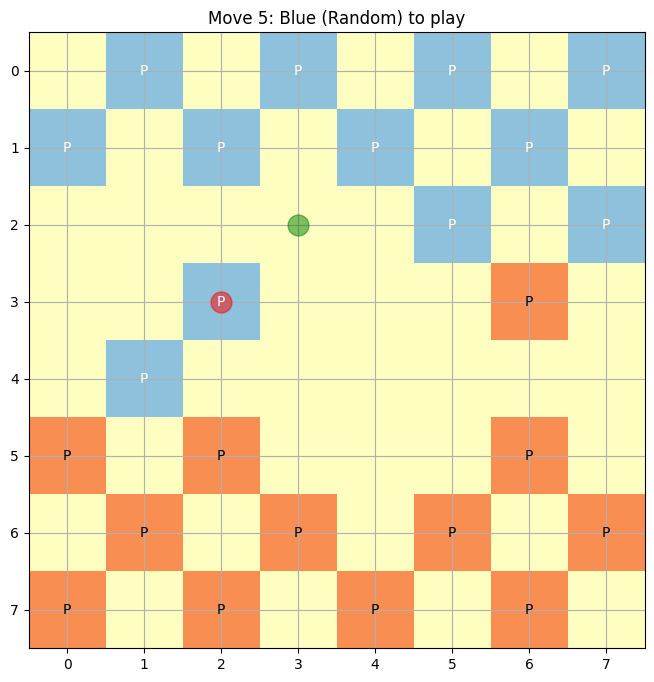

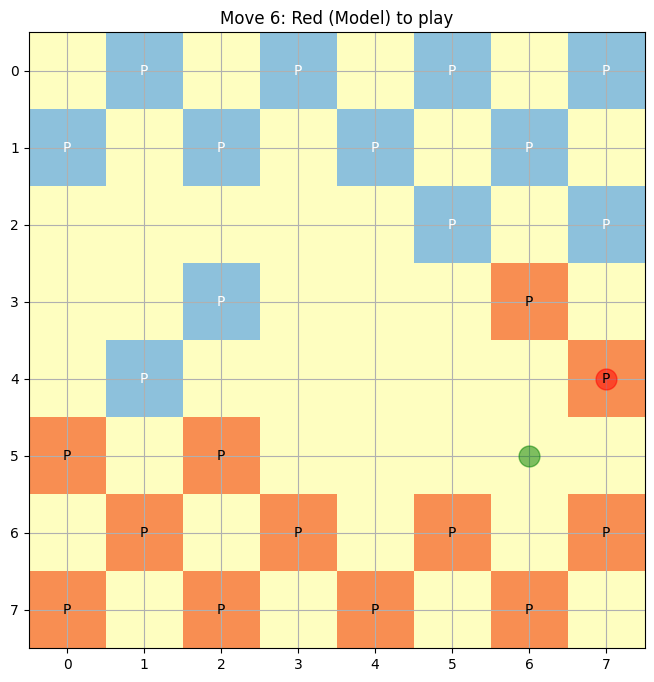

Model's confidence: 0.50


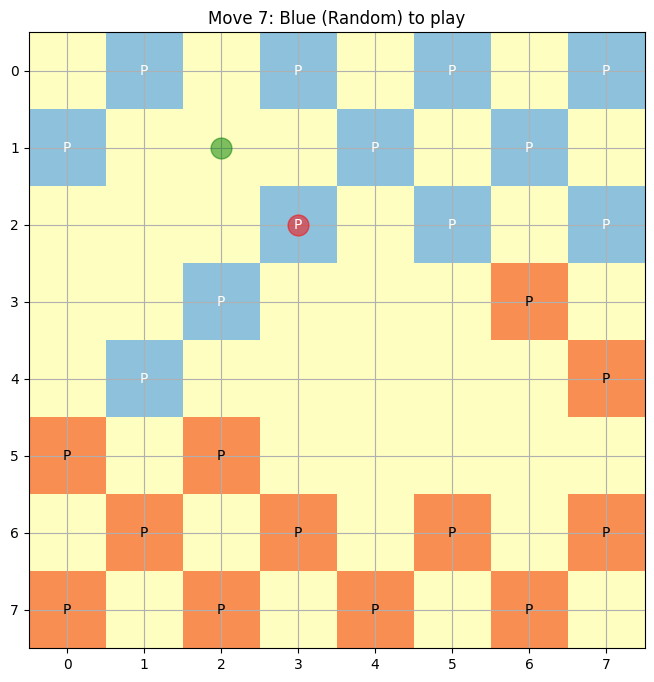

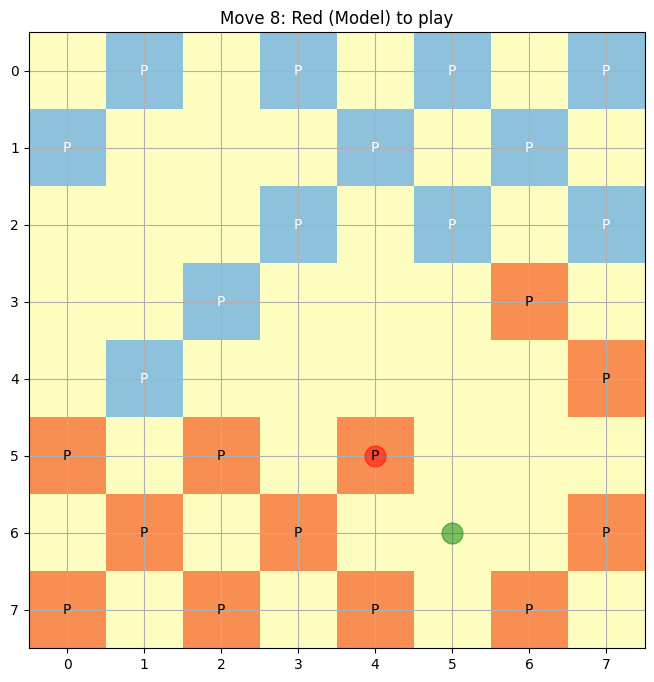

Model's confidence: 0.50


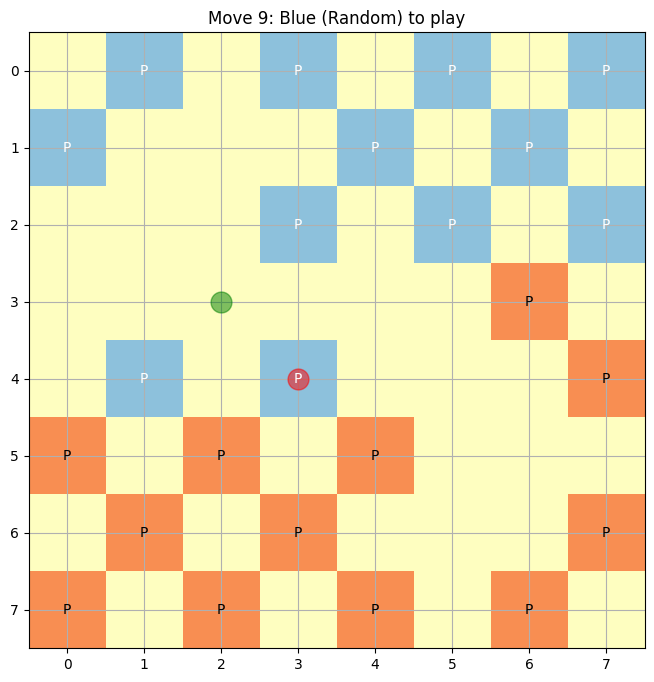

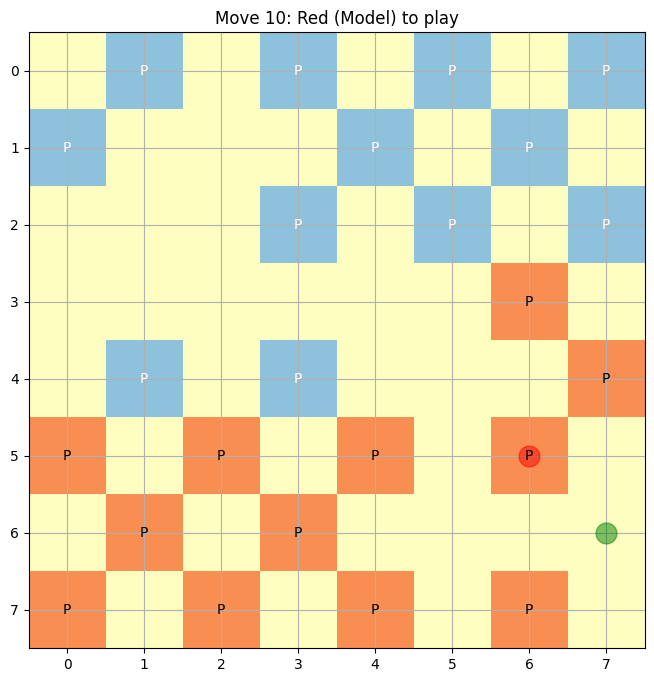

Model's confidence: 0.50


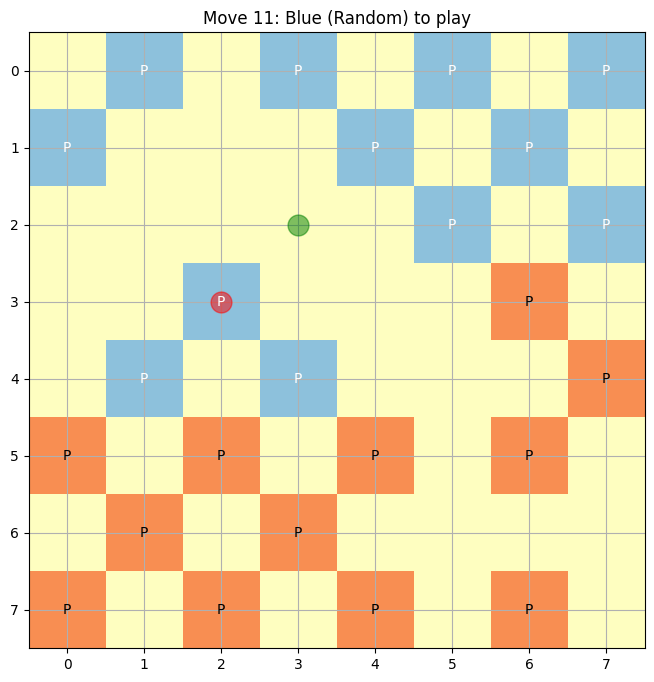

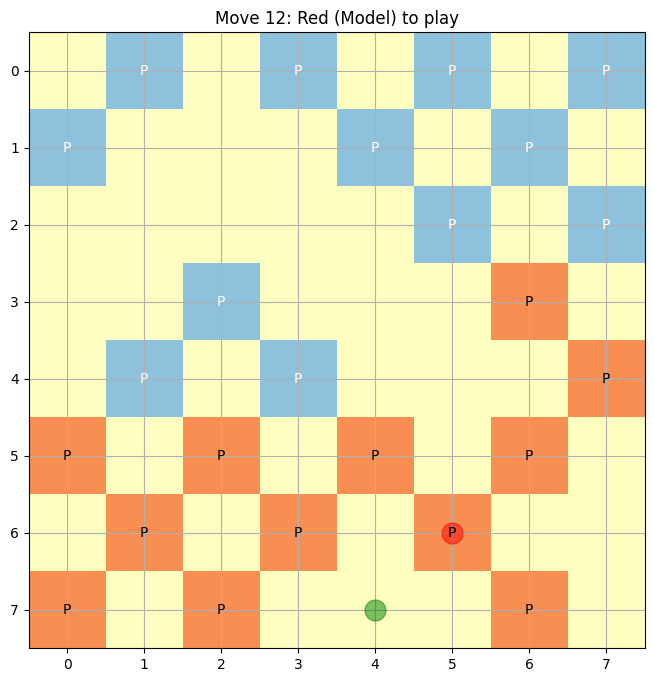

Model's confidence: 0.50


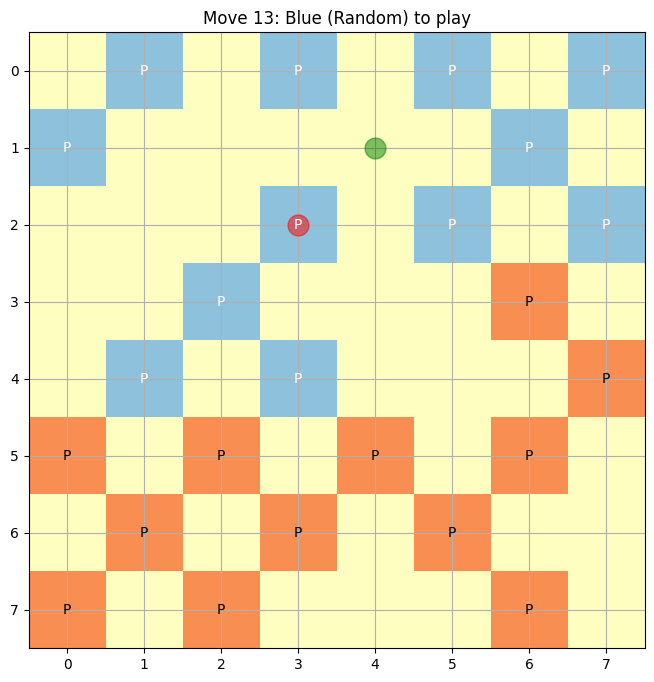

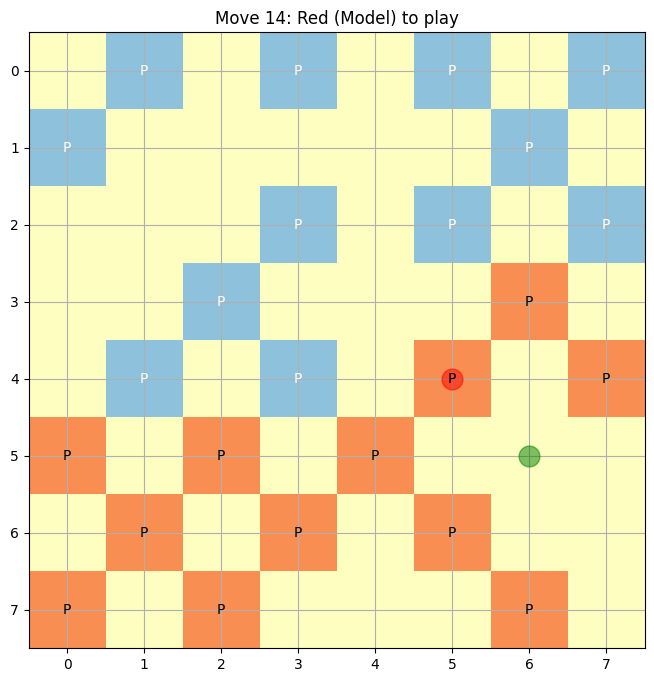

Model's confidence: 0.50


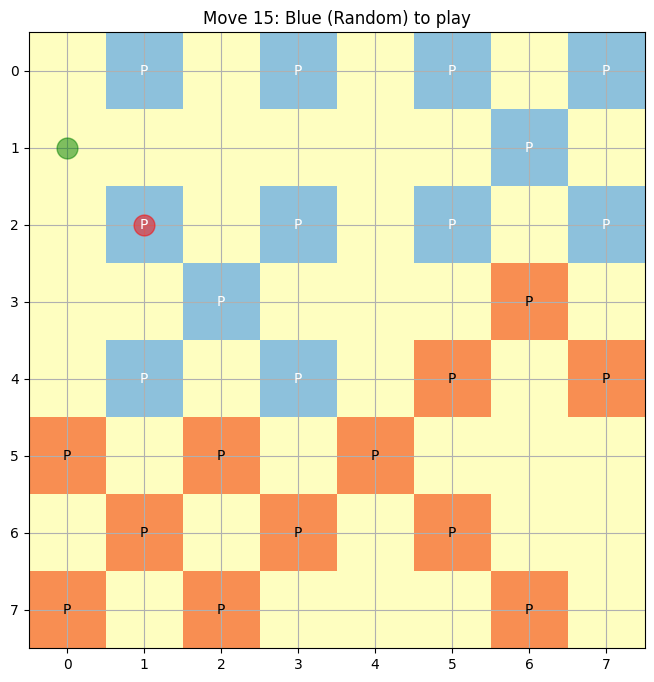

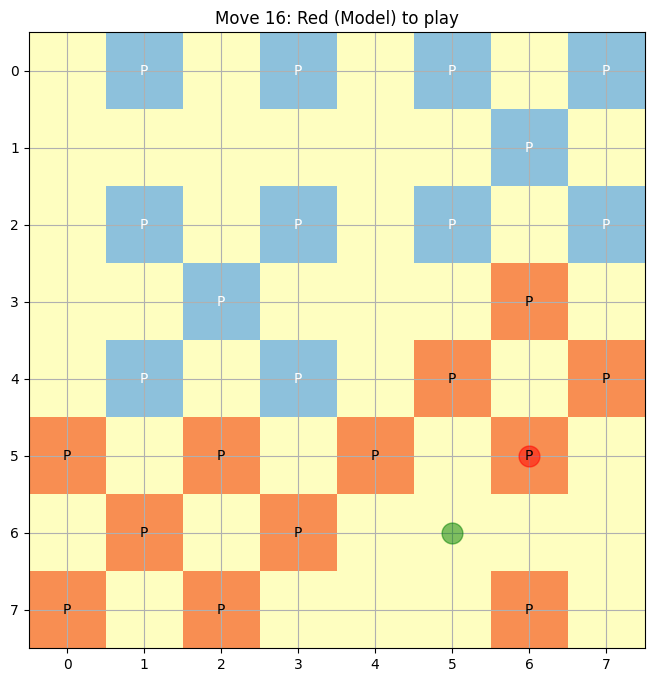

Model's confidence: 0.50


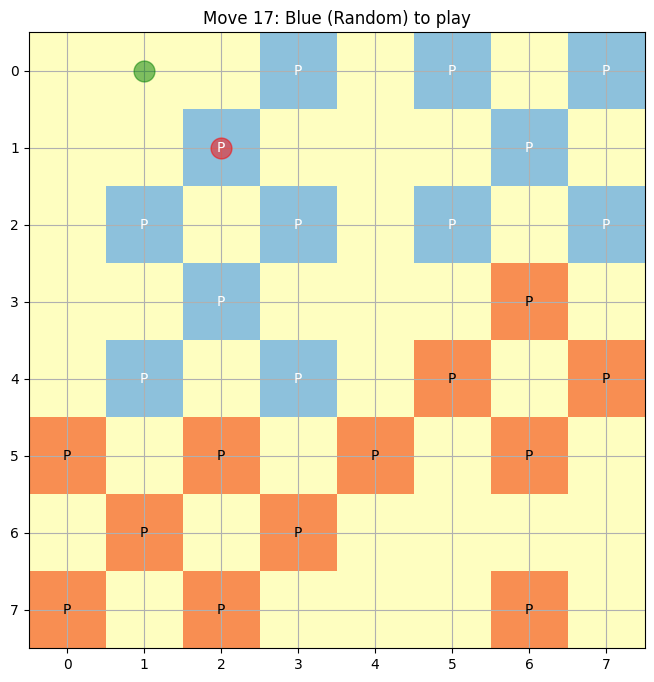

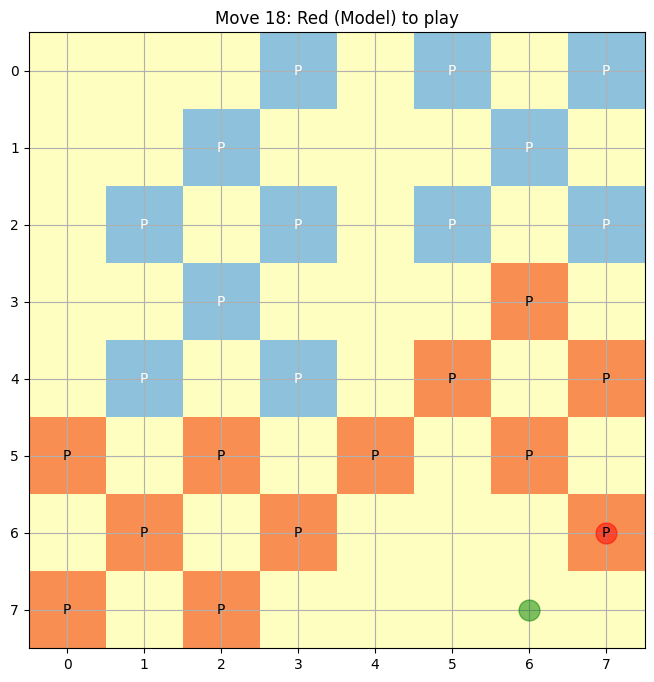

Model's confidence: 0.50


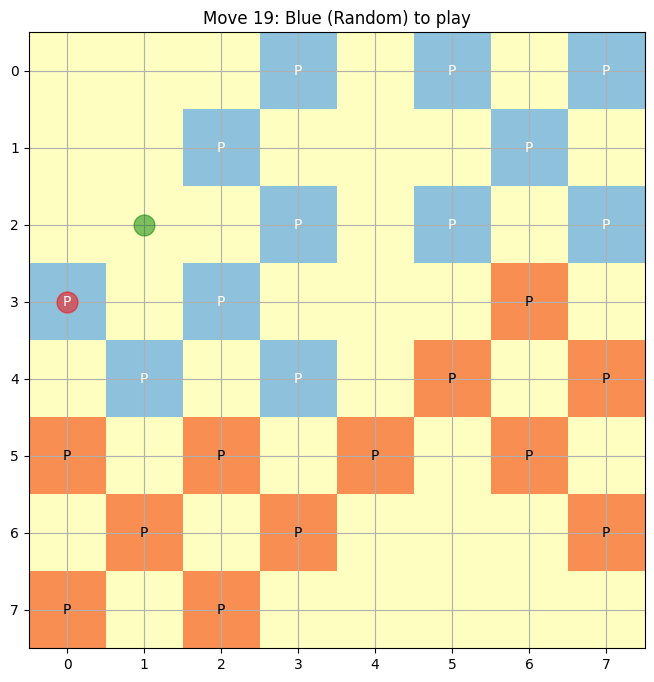

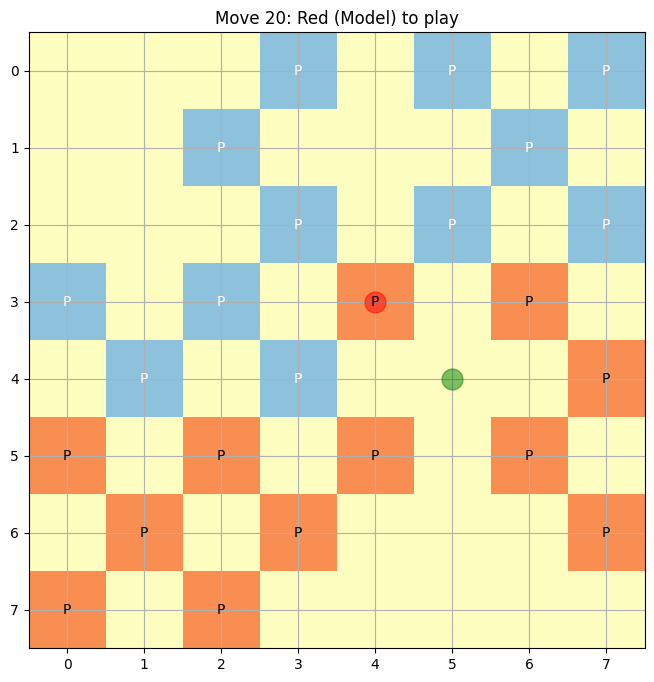

Model's confidence: 0.50


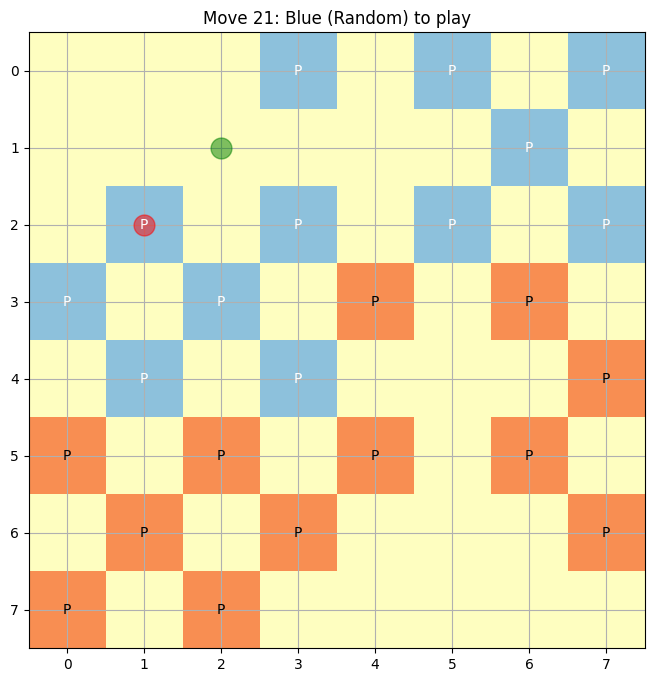

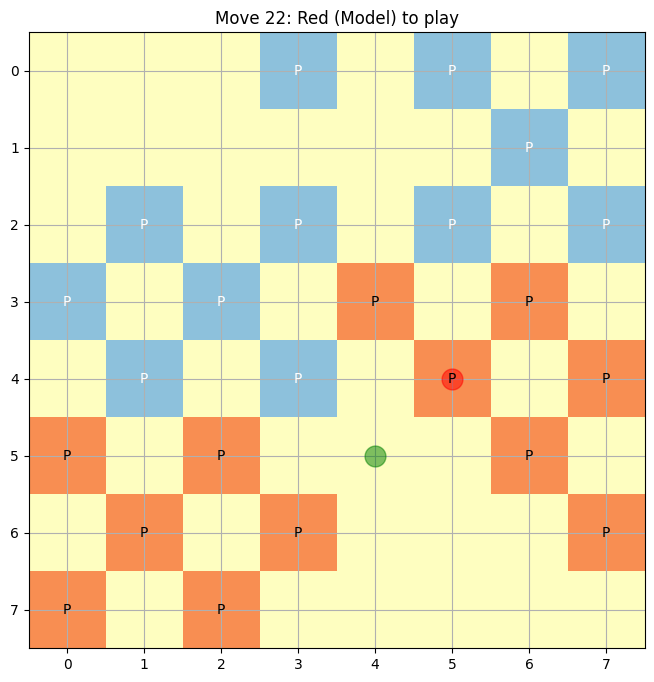

Model's confidence: 0.50


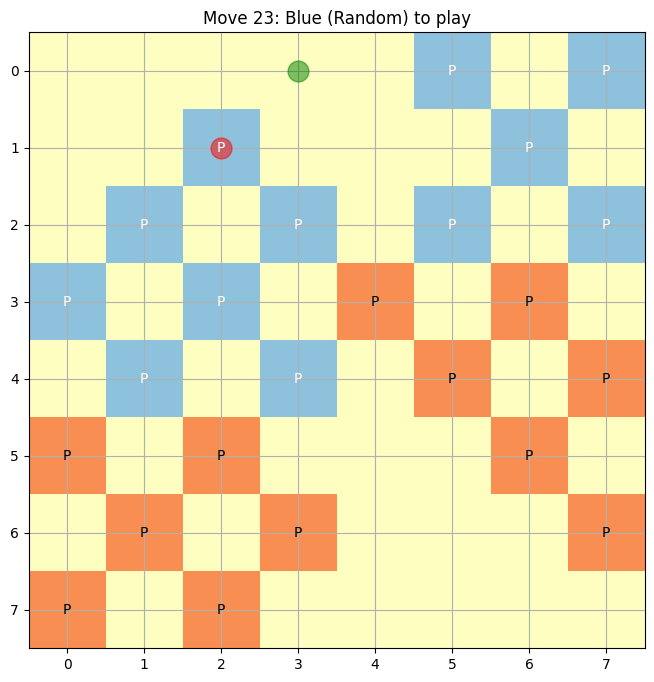

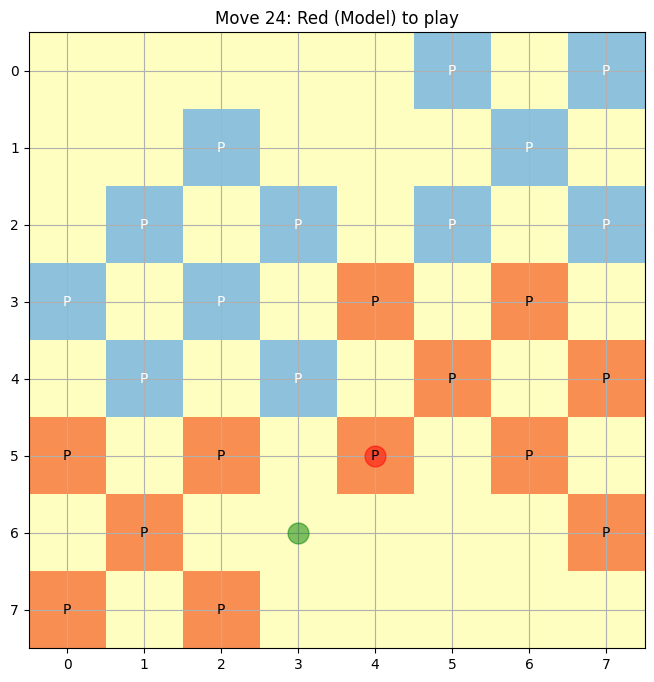

Model's confidence: 0.50


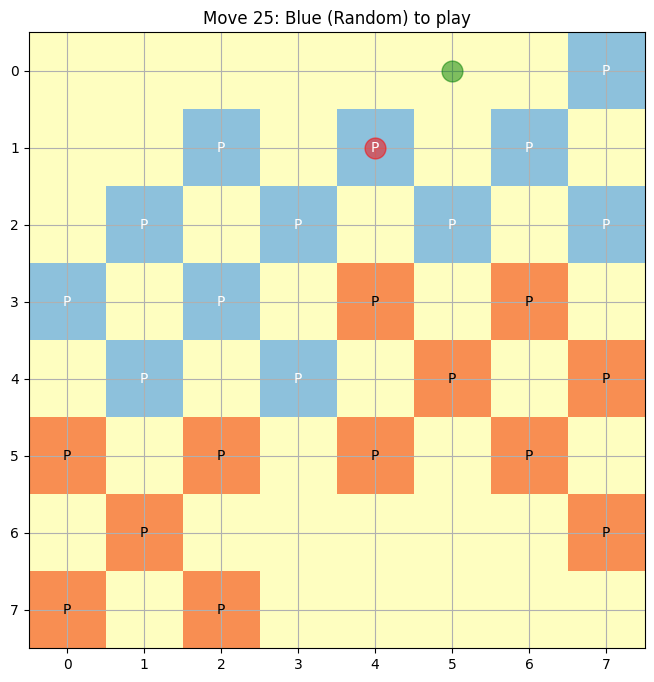

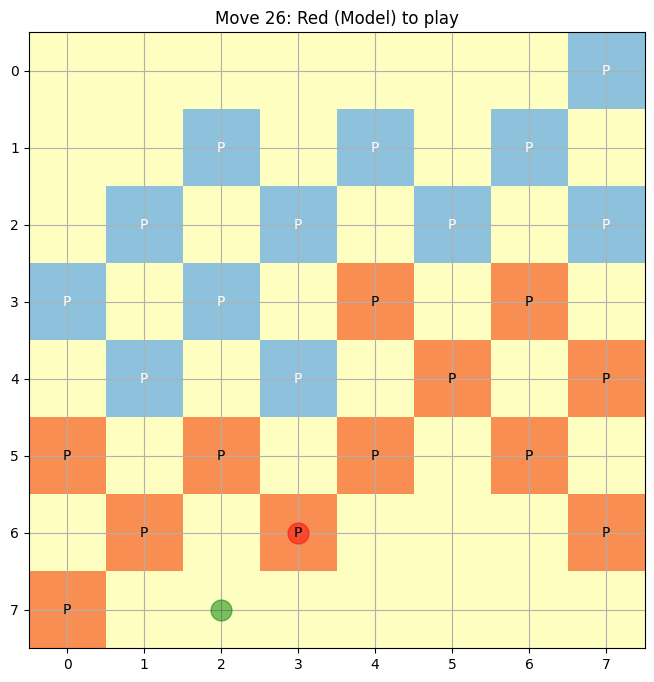

Game Over! Blue (Random) wins!
Game completed in 26 moves.


In [92]:
visualize_game(model)